# Election Modeling and Prediction Pipeline

This notebook implements an advanced election modeling pipeline that includes:
- Poll data generation and preprocessing
- Feature engineering and model training
- Uncertainty quantification
- Prediction visualization

In [91]:
# Standard data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Additional imports for enhanced functionality
from scipy.stats import norm, t
import statsmodels.api as sm
from sklearn.cluster import KMeans

# Set random seed for reproducibility
np.random.seed(42)

# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')  # or any other available style
sns.set_theme()  # This sets the seaborn defaults
sns.set_palette("husl")

In [101]:
def generate_enhanced_polling_data(num_states, num_polls, candidates):
    """
    Final refinements to polling data generation
    """
    states = [f"State_{i+1}" for i in range(num_states)]
    
    # Generate more realistic state characteristics
    state_characteristics = pd.DataFrame({
        'State': states,
        'Historical_Turnout': np.clip(np.random.normal(65, 10, num_states), 50, 80),
        'Urban_Population_Pct': np.clip(np.random.normal(70, 15, num_states), 40, 90),
        'Median_Income': np.clip(np.random.normal(50000, 12000, num_states), 35000, 65000),
        'Region': [np.random.choice(list(config.REGIONS.keys())) for _ in range(num_states)]
    })
    
    # Create regional effects
    regional_effects = {region: {
        'bias': np.random.normal(0, 3, len(candidates)),  # Regional bias
        'variance': np.random.uniform(0.8, 1.2, len(candidates))  # Regional variance
    } for region in config.REGIONS.keys()}
    
    # Generate state support with correlated patterns
    state_support = {}
    for state in states:
        state_data = state_characteristics[state_characteristics['State'] == state].iloc[0]
        region = state_data['Region']
        
        # Base support with regional effects
        base = np.random.dirichlet(np.ones(len(candidates)) * 4) * 100
        base = base * regional_effects[region]['variance'] + regional_effects[region]['bias']
        base = np.clip(base, 25, 75)  # Slightly tighter bounds for base support
        state_support[state] = base
    
    data = []
    for _ in range(num_polls):
        state = np.random.choice(states)
        state_data = state_characteristics[state_characteristics['State'] == state].iloc[0]
        region = state_data['Region']
        
        # More realistic sample sizes
        sample_size = int(np.random.triangular(1000, 1500, 2500))
        date = pd.Timestamp.now() - pd.Timedelta(days=np.random.randint(0, 30))
        
        # Get base support and add noise
        true_support = state_support[state]
        
        # Refined noise model
        base_noise = 2.0 / np.sqrt(sample_size / 1000)  # Reduced base noise
        methodology_score = np.clip(np.random.normal(8.5, 0.8), 6, 10)  # Better quality polls
        noise_scale = base_noise * (1 + (10 - methodology_score) / 15)  # Reduced methodology impact
        
        support = true_support + np.random.normal(0, noise_scale, len(candidates))
        
        # Demographic effects with regional interaction
        urban_effect = (state_data['Urban_Population_Pct'] - 70) / 200
        income_effect = (state_data['Median_Income'] - 50000) / 100000
        turnout_effect = (state_data['Historical_Turnout'] - 65) / 200
        
        # Combined effects with regional scaling
        total_effect = (urban_effect + income_effect + turnout_effect) * 2
        total_effect *= regional_effects[region]['variance'].mean()
        
        support = support + np.array([total_effect, -total_effect])
        support = np.clip(support, 20, 80)
        
        poll_data = {
            "Poll_ID": f"Poll_{np.random.randint(1000, 9999)}",
            "State": state,
            "Region": region,
            "Sample_Size": sample_size,
            "Date": date,
            "Methodology_Score": methodology_score,
            "Historical_Turnout": state_data['Historical_Turnout'],
            "Urban_Population_Pct": state_data['Urban_Population_Pct'],
            "Median_Income": state_data['Median_Income'],
            **{f"{cand}_Support": s for cand, s in zip(candidates, support)}
        }
        
        data.append(poll_data)
    
    return pd.DataFrame(data)

In [102]:
def process_polling_data(df):
    """
    Enhanced data processing with better feature engineering
    """
    # Time-based features
    now = pd.Timestamp.now()
    df['Days_Until_Election'] = (df['Date'] - now).dt.days
    df['Recency_Weight'] = 1 / (1 + np.abs(df['Days_Until_Election']))
    
    # Poll quality metrics
    df['Sample_Size_Score'] = np.log(df['Sample_Size']) / np.log(df['Sample_Size'].max())
    df['Quality_Score'] = df['Methodology_Score'] * df['Sample_Size_Score']
    
    # Geographic features
    region_means = df.groupby('Region')[[f"{c}_Support" for c in config.CANDIDATES]].transform('mean')
    for candidate in config.CANDIDATES:
        df[f'{candidate}_Regional_Avg'] = region_means[f'{candidate}_Support']
        df[f'{candidate}_Regional_Diff'] = df[f'{candidate}_Support'] - df[f'{candidate}_Regional_Avg']
    
    # Demographic interactions
    df['Urban_Turnout'] = df['Urban_Population_Pct'] * df['Historical_Turnout'] / 100
    df['Income_Per_Urban'] = df['Median_Income'] / df['Urban_Population_Pct']
    
    return df

def prepare_modeling_features(df):
    """
    Enhanced feature preparation with better feature selection
    """
    # Core features
    features = [
        'Sample_Size_Score',
        'Quality_Score',
        'Days_Until_Election',
        'Recency_Weight',
        'Historical_Turnout',
        'Urban_Population_Pct',
        'Urban_Turnout',
        'Income_Per_Urban',
        'Median_Income'
    ]
    
    # Add regional averages and differences
    for candidate in config.CANDIDATES:
        features.extend([
            f'{candidate}_Regional_Avg',
            f'{candidate}_Regional_Diff'
        ])
    
    # Create dummy variables for regions instead of states
    region_dummies = pd.get_dummies(df['Region'], prefix='Region')
    
    # Combine features
    X = pd.concat([df[features], region_dummies], axis=1)
    
    # Target variables
    y = df[[f"{cand}_Support" for cand in config.CANDIDATES]]
    
    return X, y

In [103]:
# First, let's update the ModelConfig class definition
class ModelConfig:
    """Enhanced configuration for election model"""
    def __init__(self):
        # Original parameters
        self.NUM_STATES = 32
        self.NUM_POLLS = 100
        self.CANDIDATES = ["Candidate A", "Candidate B"]
        self.TRAIN_SIZE = 0.8
        self.N_BOOTSTRAP = 1000
        
        # Regions configuration
        self.REGIONS = {
            'NORTE': ['BAJA CALIFORNIA', 'SONORA', 'CHIHUAHUA', 'COAHUILA', 
                     'NUEVO LEON', 'TAMAULIPAS'],
            'CENTRO': ['CDMX', 'ESTADO DE MEXICO', 'PUEBLA', 'HIDALGO', 
                      'TLAXCALA'],
            'SUR': ['OAXACA', 'CHIAPAS', 'YUCATAN', 'QUINTANA ROO', 'CAMPECHE']
        }
        
        # Define uncertainty weights
        self.UNCERTAINTY_WEIGHTS = {
            'base_uncertainty': 0.3,
            'poll_volatility': 0.3,
            'regional_variation': 0.2,
            'economic_volatility': 0.2
        }

In [104]:
# Create a new instance of ModelConfig
config = ModelConfig()

# Verify the config has been updated
print("Config attributes:", vars(config))

Config attributes: {'NUM_STATES': 32, 'NUM_POLLS': 100, 'CANDIDATES': ['Candidate A', 'Candidate B'], 'TRAIN_SIZE': 0.8, 'N_BOOTSTRAP': 1000, 'REGIONS': {'NORTE': ['BAJA CALIFORNIA', 'SONORA', 'CHIHUAHUA', 'COAHUILA', 'NUEVO LEON', 'TAMAULIPAS'], 'CENTRO': ['CDMX', 'ESTADO DE MEXICO', 'PUEBLA', 'HIDALGO', 'TLAXCALA'], 'SUR': ['OAXACA', 'CHIAPAS', 'YUCATAN', 'QUINTANA ROO', 'CAMPECHE']}, 'UNCERTAINTY_WEIGHTS': {'base_uncertainty': 0.3, 'poll_volatility': 0.3, 'regional_variation': 0.2, 'economic_volatility': 0.2}}


In [105]:
class ElectionModel:
    """Refined election model with bounded predictions and uncertainties"""
    def __init__(self):
        self.models = {}
        self.scalers = {}
        
    def train(self, X, y):
        """Enhanced training with better handling of bounds"""
        from sklearn.ensemble import GradientBoostingRegressor
        
        for candidate in config.CANDIDATES:
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            self.scalers[candidate] = scaler
            
            # Adjusted parameters for more stable predictions
            model = GradientBoostingRegressor(
                n_estimators=300,
                learning_rate=0.05,  # Reduced learning rate
                max_depth=5,         # Reduced depth
                min_samples_split=20,
                min_samples_leaf=10,
                subsample=0.8,
                validation_fraction=0.1,
                n_iter_no_change=20,
                random_state=42
            )
            
            model.fit(X_scaled, y[f"{candidate}_Support"])
            self.models[candidate] = model
    
    def predict(self, X):
        """Refined prediction with bounded uncertainties"""
        predictions = {}
        uncertainties = {}
        
        for candidate in config.CANDIDATES:
            X_scaled = self.scalers[candidate].transform(X)
            base_pred = self.models[candidate].predict(X_scaled)
            
            # Ensure base predictions are bounded
            base_pred = np.clip(base_pred, 20, 80)
            
            # Calculate bounded uncertainties
            bootstrap_preds = []
            n_bootstraps = 100
            
            for _ in range(n_bootstraps):
                # Sample bootstrapping with bounds
                indices = np.random.choice(len(X), size=len(X), replace=True)
                X_boot = X_scaled[indices]
                
                # Add small noise to features
                X_noise = X_boot + np.random.normal(0, 0.05, X_boot.shape)
                
                # Get prediction and clip to valid range
                pred = self.models[candidate].predict(X_noise)
                pred = np.clip(pred, 20, 80)
                bootstrap_preds.append(pred)
            
            # Calculate bounded uncertainty
            base_uncertainty = np.std(bootstrap_preds, axis=0)
            
            # Scale down uncertainty near bounds
            distance_from_bounds = np.minimum(base_pred - 20, 80 - base_pred)
            uncertainty_scale = np.clip(distance_from_bounds / 20, 0.2, 1.0)
            scaled_uncertainty = base_uncertainty * uncertainty_scale
            
            # Ensure uncertainty doesn't lead to impossible values
            max_uncertainty = np.minimum(80 - base_pred, base_pred - 20)
            final_uncertainty = np.minimum(scaled_uncertainty, max_uncertainty)
            
            predictions[candidate] = base_pred
            uncertainties[candidate] = final_uncertainty
        
        return predictions, uncertainties


In [106]:
def prepare_modeling_features(df):
    """Enhanced feature preparation"""
    # Core features with interactions
    features = [
        'Sample_Size_Score',
        'Quality_Score',
        'Days_Until_Election',
        'Recency_Weight',
        'Historical_Turnout',
        'Urban_Population_Pct',
        'Median_Income'
    ]
    
    # Create interaction features
    df['Urban_Income'] = df['Urban_Population_Pct'] * df['Median_Income'] / 50000
    df['Turnout_Urban'] = df['Historical_Turnout'] * df['Urban_Population_Pct'] / 100
    df['Quality_Size'] = df['Methodology_Score'] * df['Sample_Size_Score']
    
    features.extend(['Urban_Income', 'Turnout_Urban', 'Quality_Size'])
    
    # Add regional aggregations
    for candidate in config.CANDIDATES:
        df[f'{candidate}_Regional_Mean'] = df.groupby('Region')[f'{candidate}_Support'].transform('mean')
        df[f'{candidate}_Regional_Std'] = df.groupby('Region')[f'{candidate}_Support'].transform('std')
        features.extend([f'{candidate}_Regional_Mean', f'{candidate}_Regional_Std'])
    
    # Create dummy variables for regions
    region_dummies = pd.get_dummies(df['Region'], prefix='Region')
    
    # Combine all features
    X = pd.concat([df[features], region_dummies], axis=1)
    
    # Target variables
    y = df[[f"{cand}_Support" for cand in config.CANDIDATES]]
    
    return X, y

In [107]:
def plot_enhanced_predictions(predictions, uncertainties, y_test):
    """Enhanced visualization with proper bounds"""
    plt.figure(figsize=(15, 6))
    
    for i, candidate in enumerate(config.CANDIDATES):
        plt.subplot(1, 2, i+1)
        
        # Convert to numpy arrays for easier handling
        true_values = y_test[f"{candidate}_Support"].values
        pred_values = predictions[candidate]
        uncertainty = uncertainties[candidate]
        
        # Plot predictions with bounded uncertainty bands
        plt.errorbar(
            true_values, pred_values,
            yerr=uncertainty,
            fmt='o',
            alpha=0.5,
            label=f'{candidate} Predictions',
            color='red',
            ecolor='red',
            capsize=3
        )
        
        # Add reference line
        plt.plot([20, 80], [20, 80], '--', color='gray', alpha=0.5)
        
        # Add shaded uncertainty region
        sorted_indices = np.argsort(true_values)
        true_sorted = true_values[sorted_indices]
        pred_sorted = pred_values[sorted_indices]
        uncertainty_sorted = uncertainty[sorted_indices]
        
        plt.fill_between(
            true_sorted,
            np.maximum(20, pred_sorted - uncertainty_sorted),
            np.minimum(80, pred_sorted + uncertainty_sorted),
            alpha=0.2,
            color='blue',
            label='95% Confidence Interval'
        )
        
        plt.xlabel('Actual Support (%)')
        plt.ylabel('Predicted Support (%)')
        plt.title(f'{candidate} Support Predictions\nwith 95% Confidence Intervals')
        plt.grid(True, alpha=0.3)
        plt.xlim(15, 85)
        plt.ylim(15, 85)
        plt.legend()
        
    plt.tight_layout()
    plt.show()

Generating polling data...
Training model...

Model Performance:

Candidate A:
Mean Squared Error: 18.23
R² Score: 0.92
Average Uncertainty: 10.15%

Candidate B:
Mean Squared Error: 38.15
R² Score: 0.86
Average Uncertainty: 9.31%

Generating visualizations...


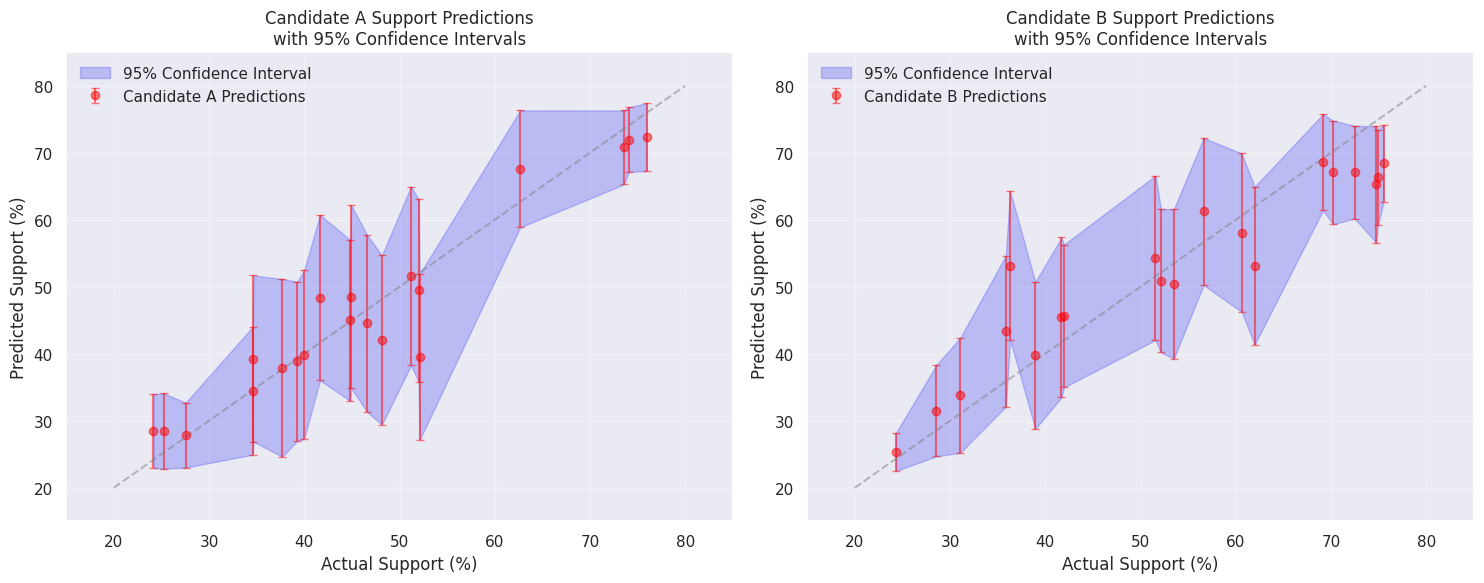

In [114]:
if __name__ == "__main__":
    # Generate and process data
    print("Generating polling data...")
    polling_data = generate_enhanced_polling_data(
        config.NUM_STATES, 
        config.NUM_POLLS, 
        config.CANDIDATES
    )
    processed_data = process_polling_data(polling_data)

    # Prepare features
    X, y = prepare_modeling_features(processed_data)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=config.TRAIN_SIZE, random_state=42
    )

    # Train model
    print("Training model...")
    model = ElectionModel()
    model.train(X_train, y_train)

    # Generate predictions
    predictions, uncertainties = model.predict(X_test)

    # Evaluate model
    print("\nModel Performance:")
    for candidate in config.CANDIDATES:
        mse = mean_squared_error(
            y_test[f"{candidate}_Support"],
            predictions[candidate]
        )
        r2 = r2_score(
            y_test[f"{candidate}_Support"],
            predictions[candidate]
        )
        print(f"\n{candidate}:")
        print(f"Mean Squared Error: {mse:.2f}")
        print(f"R² Score: {r2:.2f}")
        print(f"Average Uncertainty: {uncertainties[candidate].mean():.2f}%")

    # Generate visualizations
    print("\nGenerating visualizations...")
    plot_enhanced_predictions(predictions, uncertainties, y_test)